<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1, )

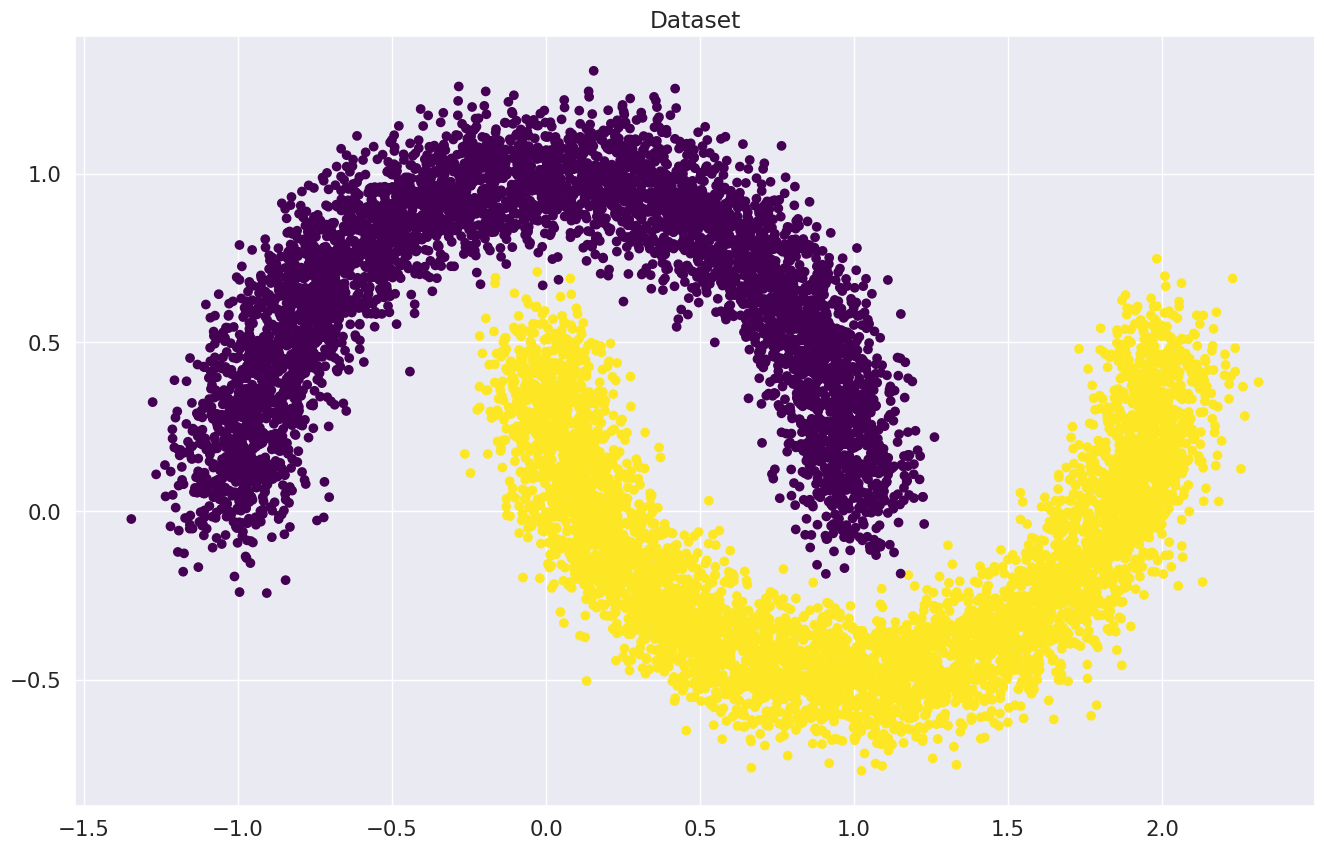

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Построим PCA для любопытства

In [ ]:
from sklearn.decomposition import PCA
X_df = pd.DataFrame(np.hstack((X,y.reshape(-1,1))), columns=["X", "Y", "label"])
X_df["label"] = X_df["label"].astype(int)
pca = PCA(n_components = 2)
trans = X_df[["X", "Y"]].mean() # центрируем облако перед PCA
X_df["X"] -= trans.X
X_df["Y"] -= trans.Y
X_df[["pca1", "pca2"]] = pca.fit_transform(X_df[["X", "Y"]])

In [ ]:
# информация о PCA
print('Mean vector: ', pca.mean_,'Projection: ', pca.components_, 'Explained variance ratio: ', pca.explained_variance_ratio_)

Mean vector:  [ 1.55822022e-15 -6.02895511e-16] Projection:  [[-0.94811045  0.31794115]
 [ 0.31794115  0.94811045]] Explained variance ratio:  [0.81347048 0.18652952]


In [ ]:
# собственные вектора нормированные
print(np.linalg.norm(pca.components_[0]),"\n", np.linalg.norm(pca.components_[1]))

0.9999999999999999 
 0.9999999999999999


In [ ]:
# собственные вектора ортогональны
np.dot(pca.components_[0], pca.components_[1])

0.0

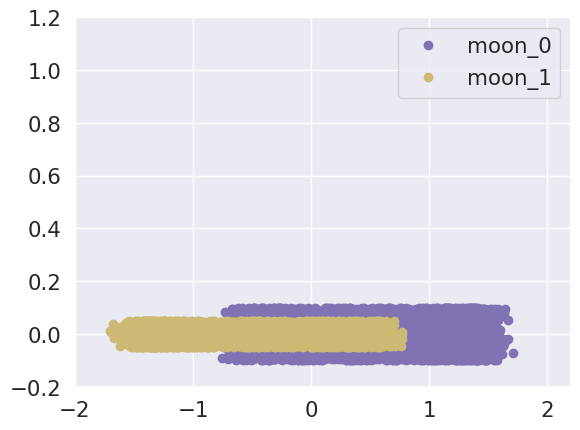

In [ ]:
# проекция на гдавную ось
y_smear = lambda n, var: np.random.uniform(-var, var, size = n) # for visualization purpurses
mag_moon = X_df.loc[X_df["label"] == 0 , "pca1"]
yell_moon = X_df.loc[X_df["label"] == 1 , "pca1"]
# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(mag_moon, y_smear(len(mag_moon), 0.1), 'mo', label='moon_0')
plt.plot(yell_moon, y_smear(len(yell_moon), 0.05), 'yo', label='moon_1')
plt.ylim((-0.2, 1.2))
plt.xlim((-2, 2.2))
plt.legend(loc = 0)

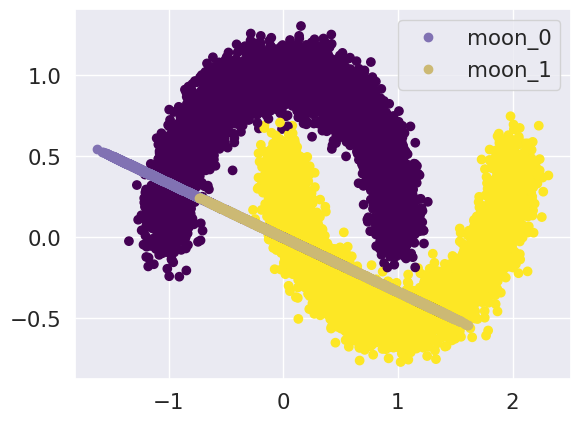

In [ ]:
# восстановим данные в 2D только по одной проекции (с потерей информации о дисперсии около 18%)
# x_pca = V*x_rec, где V матрица перехода между базисами со столбцами из собственных векторов: x_rec = V.T * x_pca
x_pca =  np.column_stack((X_df["pca1"].to_numpy(), np.zeros((len(X),))))
X_df[["X_reconstructed", "Y_reconstructed"]] = np.dot(pca.components_.T, x_pca.T).T

mag_moon_x = X_df.loc[X_df["label"] == 0 , "X_reconstructed"]
yell_moon_x = X_df.loc[X_df["label"] == 1 , "X_reconstructed"]
mag_moon_y = X_df.loc[X_df["label"] == 0 , "Y_reconstructed"]
yell_moon_y = X_df.loc[X_df["label"] == 1 , "Y_reconstructed"]
# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(mag_moon_x, mag_moon_y, 'mo', label='moon_0')
plt.plot(yell_moon_x, yell_moon_y, 'yo', label='moon_1')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
# plt.ylim((-0.2, 1.2))
# plt.xlim((-2, 2.2))
plt.legend(loc = 0)

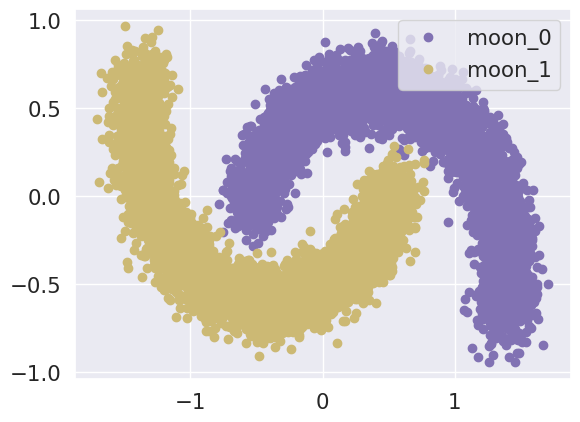

In [ ]:
# Полное пространство PCA
mag_moon_x = X_df.loc[X_df["label"] == 0 , "pca1"]
yell_moon_x = X_df.loc[X_df["label"] == 1 , "pca1"]
mag_moon_y = X_df.loc[X_df["label"] == 0 , "pca2"]
yell_moon_y = X_df.loc[X_df["label"] == 1 , "pca2"]
# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(mag_moon_x, mag_moon_y, 'mo', label='moon_0')
plt.plot(yell_moon_x, yell_moon_y, 'yo', label='moon_1')
# plt.ylim((-0.2, 1.2))
# plt.xlim((-2, 2.2))
plt.legend(loc = 0)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.LongTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.LongTensor(y_val)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle= False)

In [ ]:
# посмотрим струткуры батчей, котрые нам даёт dataloader
# видим, что  каждый батч - это 128 элементов тренировочной выборки с соответствующими таргетами
next(iter(train_dataloader))

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1))

    def forward(self, x):
        x =  self.weights @ x.T
        if self.bias:
            x +=  self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss() # комбинация сигмойды и лог-лосса (численно более устойчиво согласно документации, чем реализовывать по отдельности)
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
trainable_params = sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch)
        loss =  loss_function(outp, y_batch.float()) # сравниваем предсказани модели с таргетами в батче по лоссу
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0: # ка
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.1640625
Iteration: 100
Batch accuracy: 0.6328125
Iteration: 200
Batch accuracy: 0.6875
Iteration: 300
Batch accuracy: 0.7890625
Iteration: 400
Batch accuracy: 0.7890625
Iteration: 500
Batch accuracy: 0.7890625
Iteration: 600
Batch accuracy: 0.828125

Iteration: 693.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 369

### Визуализируем результаты

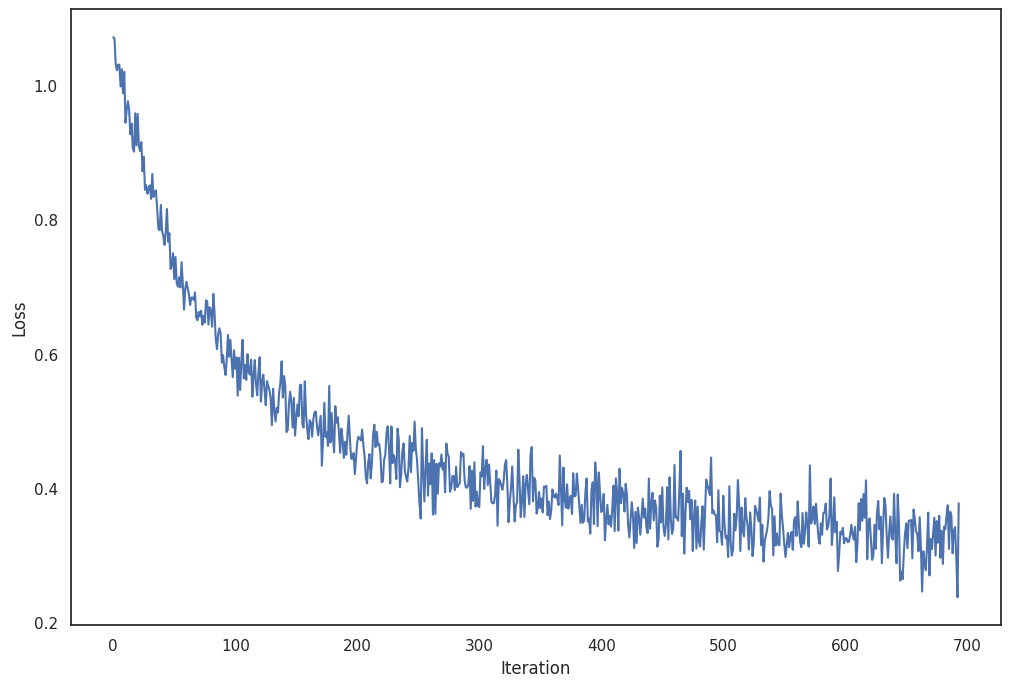

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

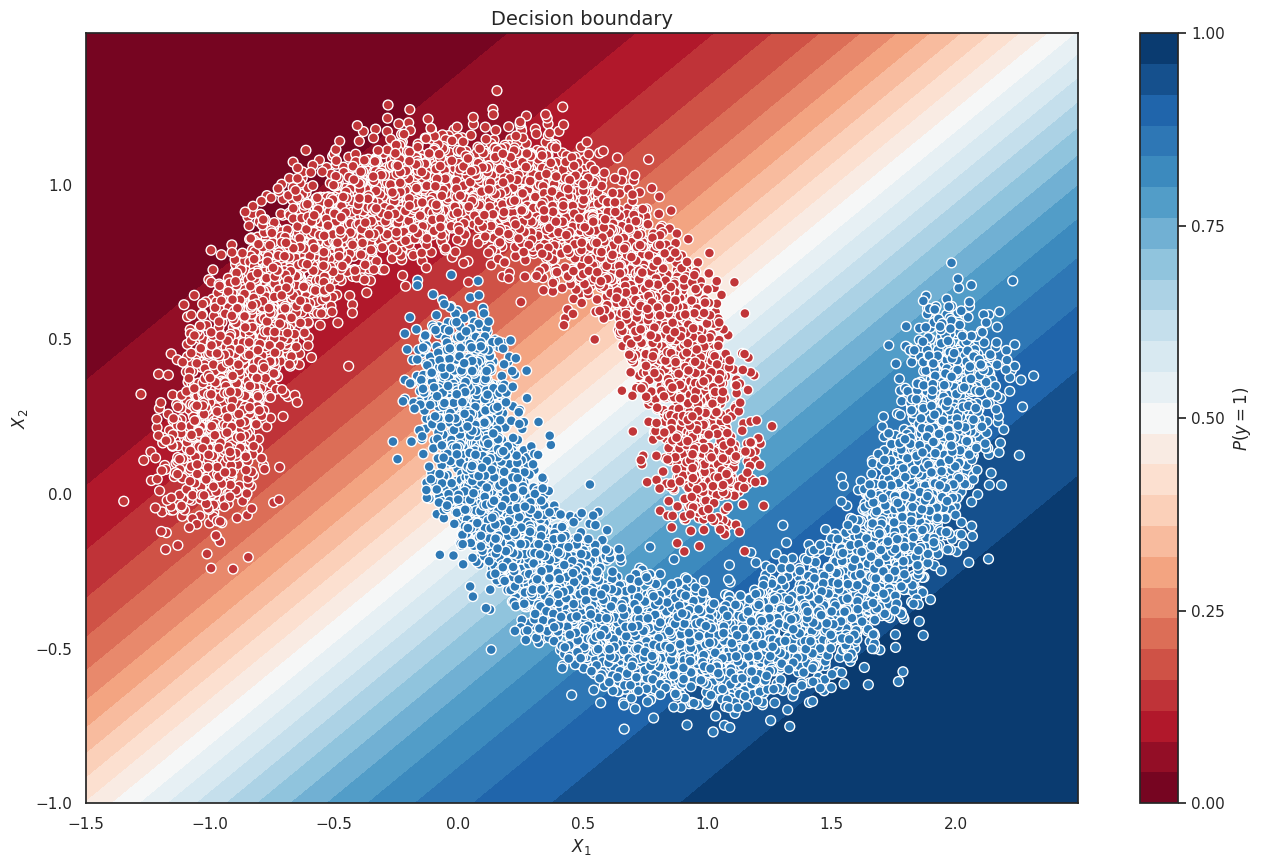

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict_log_regression(dataloader, model, threshold = 0.5):
    """
    На основе вероятностей выданных моделью и порога возвращает предсказанные таргеты {0,1}
    Нижний "месяц" суть 1-ый класс (см рисунок выше)
    """
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probs = torch.sigmoid(model(x_batch)) # вероятности пренадлежать 1 классу
        preds = (probs > threshold).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, predict_log_regression(val_dataloader, linear_regression))

0.8496

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8496

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2) # не перемешиваем тестовую выборку

100%|██████████| 9912422/9912422 [00:00<00:00, 76232835.29it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 78608496.97it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34219806.81it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17429578.01it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


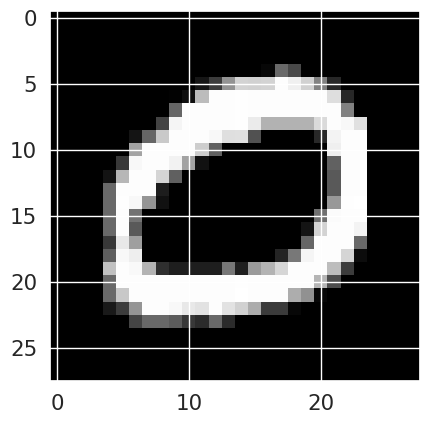

In [ ]:
# посмотрим на случайные данные из выборки
plt.imshow(train_dataloader.dataset.train_data[np.random.randint(0, len(train_dataloader))].numpy(), cmap='gray')

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128), # размер картинок 28x28
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10),
    #nn.Softmax() # nn.CrossEnthropyLoss применяет softmax  сам по себе
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
# from tqdm import tqdm_notebook
def train(model, loaders):
  log_loss = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())
  model.to(device) # переносим модель на соответствующийц вычислитель (CPU, GPU)
  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              if k == "train":
                  model.train()
                  model.zero_grad()
                  logits = model(x_batch.to(device)) # возвращает предсказанные вероятности, не забываем подгружать батчи в память девайса (обычно GPU)
                  loss = log_loss(logits, y_batch.to(device)) # nn.CrossEntropy() applies softmax under its hood
                  loss.backward()
                  optimizer.step()
              else:
                  model.eval()
                  with torch.no_grad():
                      logits = model(x_batch.to(device))

              preds = logits.argmax(-1) # индекс максимального логита из 10 суть наше предсказание
              correct = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum() # число верных предсказаний
              all = len(x_batch) # число объектов суть размер батча
              epoch_correct += correct.item() # аккумулятор числа корректных предсказаний за эпоху
              epoch_all += all # аккумулятор общего числа предсказаний за эпоху (если эпоха не дробться на целое число батчей удобнее считать здесь)

          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
  return accuracy

### Задание. Протестируйте разные функции активации. (Тестируем на 6 эпохах вместо 10)
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
   # создаём модель с заданным activation function
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 128), # размер картинок 28x28
      activation(),
      nn.Linear(128, 128),
      activation(),
      nn.Linear(128, 10),
      #nn.Softmax() # применяется в nn.CrossEnthropyLoss автоматически
    )
    # данные для обучения
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    # тренировочный цикл
    accuracy = train(model, loaders)
    return accuracy["valid"]

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [ ]:
elu_accuracy = test_activation_function(nn.ELU)
relu_accuracy = test_activation_function(nn.ReLU)
plain_accuracy = test_activation_function(Identical) # нейронная сеть без функции активации похожа на 10 логистическиx регрессий
leaky_relu_accuracy =test_activation_function(nn.LeakyReLU)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
path = "/content/drive/MyDrive/ML/"
with open(path + "elu.pickle", 'wb') as handle:
    pickle.dump(elu_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path + "relu.pickle", 'wb') as handle:
    pickle.dump(elu_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path + "plain.pickle", 'wb') as handle:
    pickle.dump(elu_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(path + "leaky_relu.pickle", 'wb') as handle:
    pickle.dump(elu_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(path, 'rb') as handle:
#     b = pickle.load(han

In [ ]:
import pickle
path = "/content/drive/MyDrive/ML/"
with open(path + "relu.pickle", 'rb') as handle:
    elu_accuracy = pickle.load(handle)


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

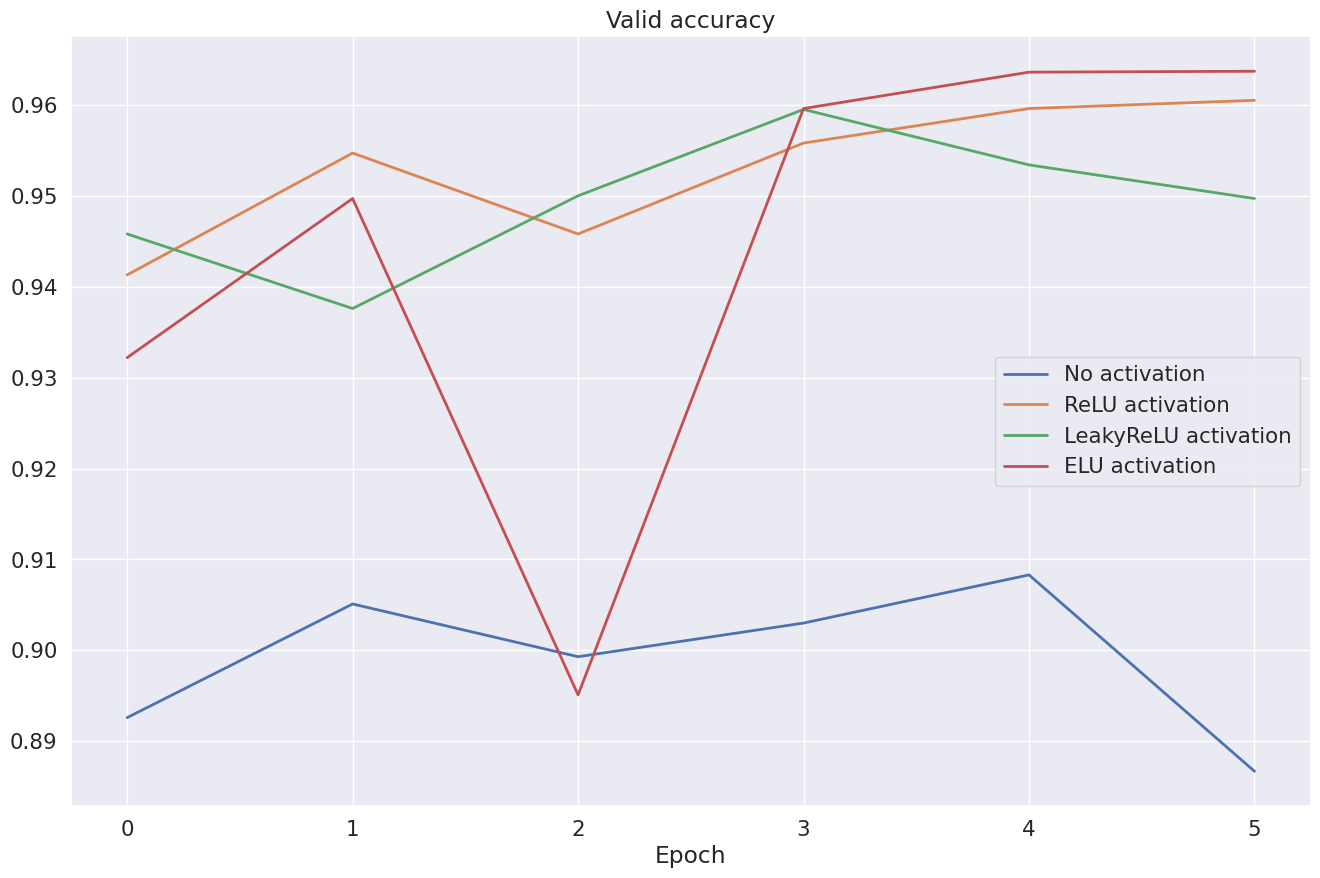

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)
max_epochs = 6
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU activation

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-03-30 16:50:37--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   260KB/s    in 0.2s    

2024-03-30 16:50:37 (260 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



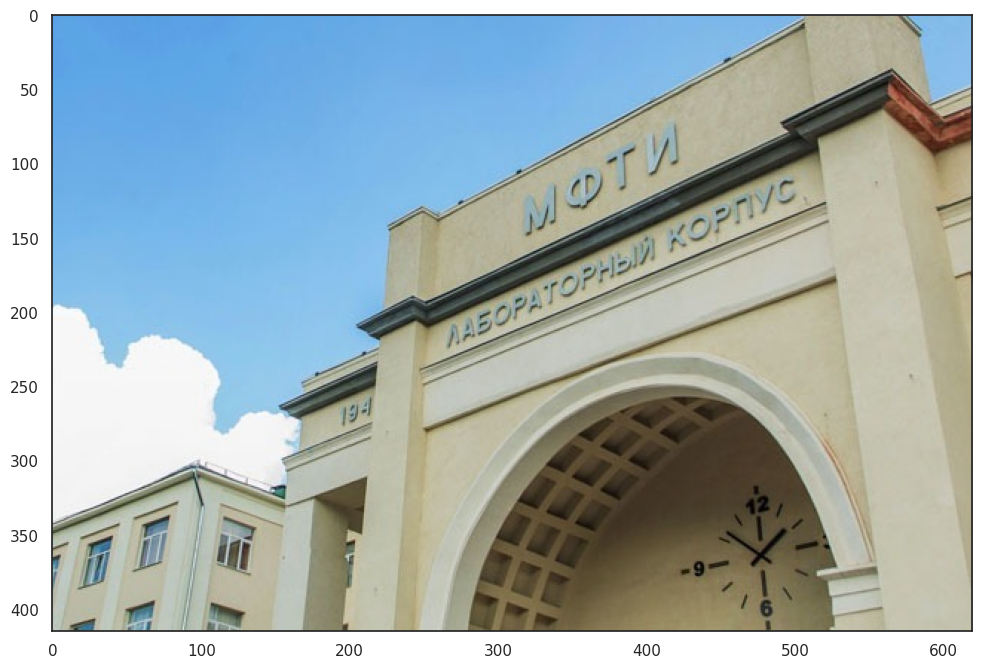

In [ ]:
import cv2
import seaborn as sns
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

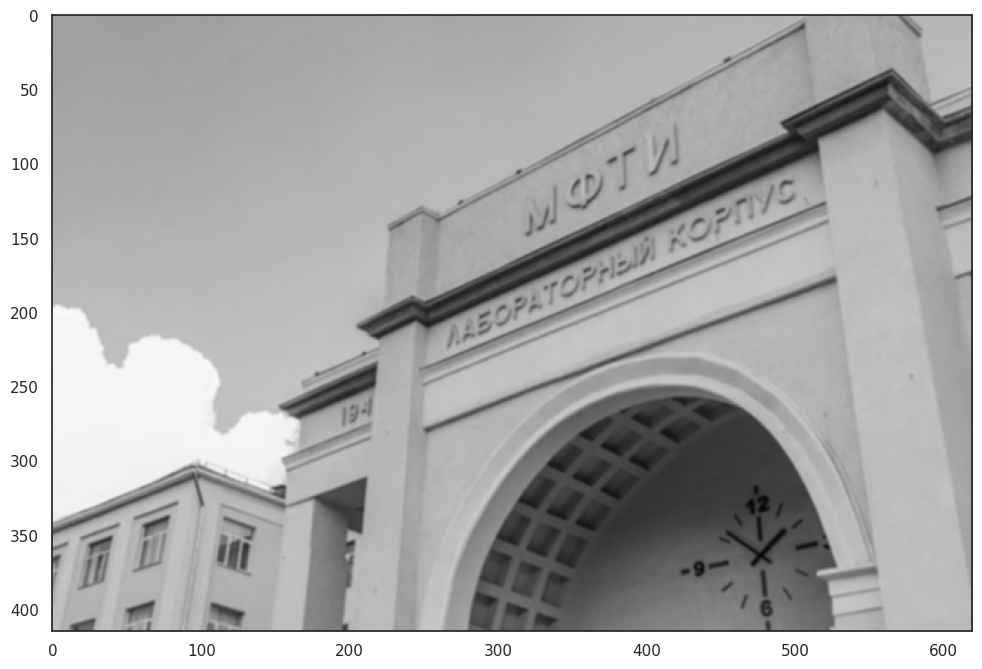

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - A

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(5*5*16,120) # !!! вычислим используя print в forward
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 5 * 5 * 16) # flatten
        #x = x.flatten()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
accuracy = train(model, loaders)

Epoch: 1
Loader: train. Accuracy: 0.9551833333333334
Loader: valid. Accuracy: 0.9809
Epoch: 2
Loader: train. Accuracy: 0.9813
Loader: valid. Accuracy: 0.9826
Epoch: 3
Loader: train. Accuracy: 0.9859
Loader: valid. Accuracy: 0.9874
Epoch: 4
Loader: train. Accuracy: 0.9886666666666667
Loader: valid. Accuracy: 0.9837
Epoch: 5
Loader: train. Accuracy: 0.9891666666666666
Loader: valid. Accuracy: 0.9862
Epoch: 6
Loader: train. Accuracy: 0.99135
Loader: valid. Accuracy: 0.9866
Epoch: 7
Loader: train. Accuracy: 0.9921833333333333
Loader: valid. Accuracy: 0.9835
Epoch: 8
Loader: train. Accuracy: 0.99195
Loader: valid. Accuracy: 0.9863
Epoch: 9
Loader: train. Accuracy: 0.9928166666666667
Loader: valid. Accuracy: 0.9867
Epoch: 10
Loader: train. Accuracy: 0.9932333333333333
Loader: valid. Accuracy: 0.9865


In [ ]:
lenet_accuracy = accuracy["valid"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
path = "/content/drive/MyDrive/ML/acc_lenet.pickle"
with open(path, 'wb') as handle:
    pickle.dump(lenet_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(path, 'rb') as handle:
#     b = pickle.load(handle)

Сравним с предыдущем пунктом

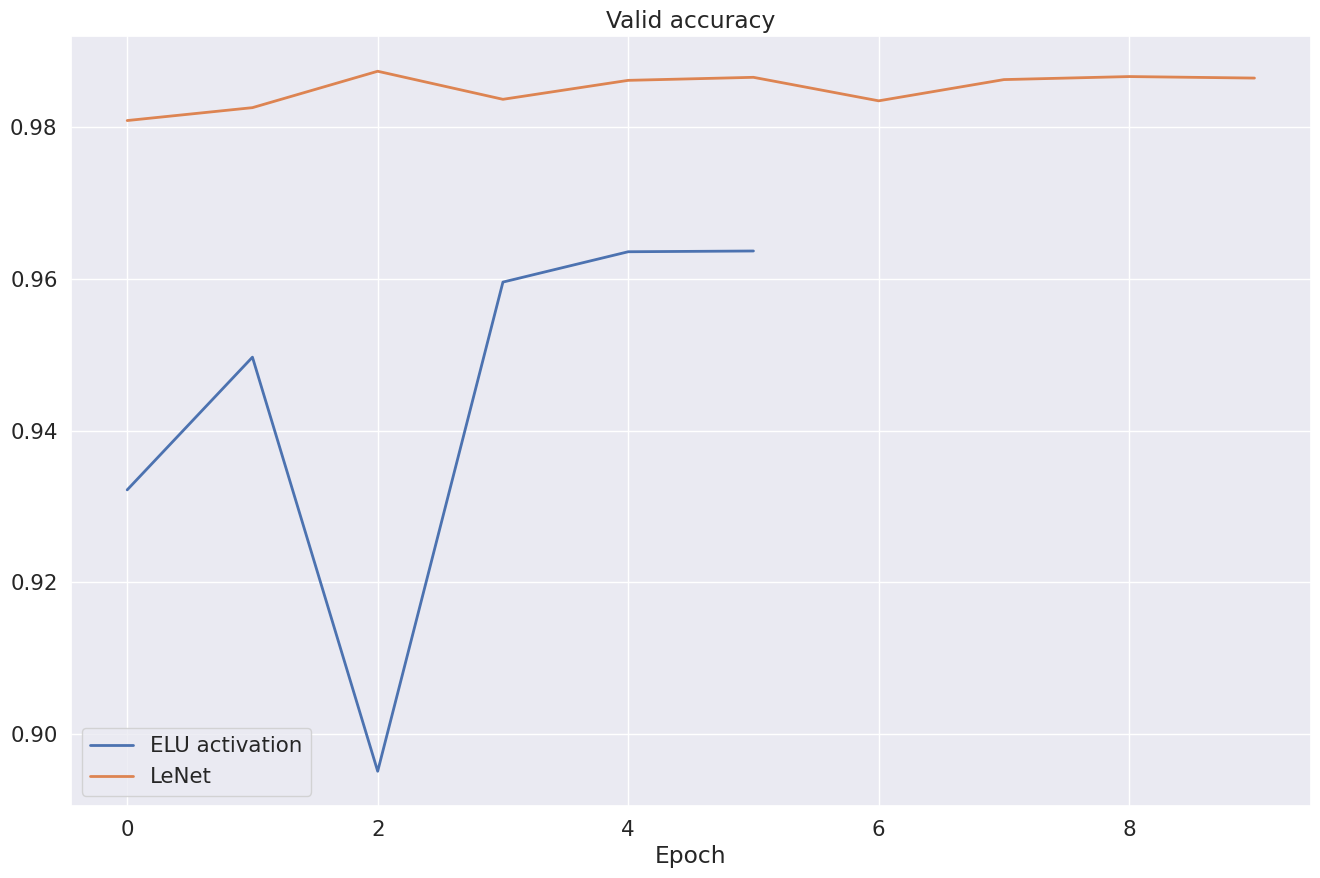

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
#plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
#plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(6), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(10), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99